<a href="https://colab.research.google.com/github/Giraldo0712/TAM_2025_2/blob/main/Ejercicios_cuaderno_7_CLustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cuadero No.7 - Clustering:

# Ejercicios

Para los siguientes puntos, utilizar la librer√≠a [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos estudiados, en caso de estar disponibles.

- Realice una comparaci√≥n de los m√©todos de clustering vistos, para generar una segmentaci√≥n de imagen a color, incluyendo la informaci√≥n de ubicaci√≥n de cada pixel (ver Cuaderno gu√≠a [tanjiro](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/tanjiro.ipynb)). Varie la cantidad de grupos (niveles o clases de segmentaci√≥n) $k\in\{3,5,7,9\}$ y presente los scores de inercia y silueta conseguidos.

- Repita el punto anterior realizando una proyecci√≥n 2D de los datos con PCA y UMAP (ver gu√≠a [reducci√≥n de dimensi√≥n](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/8_ReduccionDimension.ipynb))
 antes de generar las segmentaciones.

##Punto 1:

In [3]:
!pip -q install cudf-cu12 cuml-cu12 --extra-index-url=https://pypi.nvidia.com # Instalamos RAPIDS


##**K-means**

Procesando k=3...
k=3: Inercia=46279.77, Silhouette=0.363


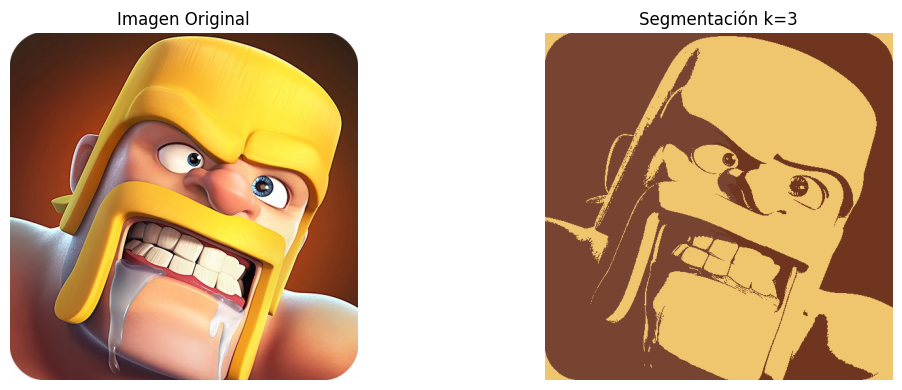

Procesando k=5...
k=5: Inercia=29442.83, Silhouette=0.362


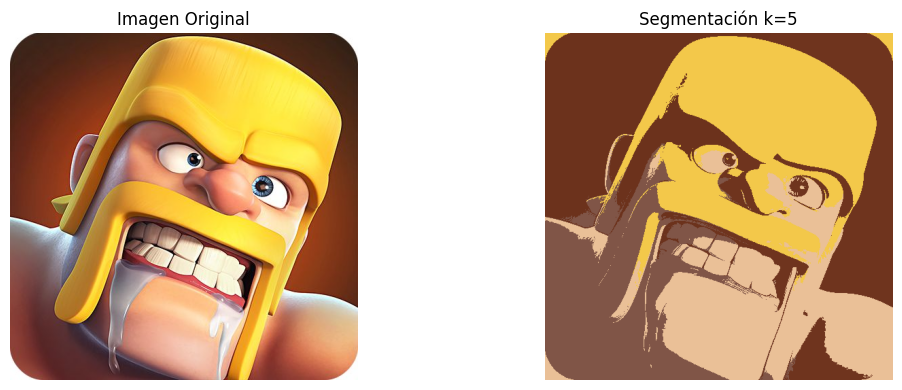

Procesando k=7...
k=7: Inercia=22757.17, Silhouette=0.369


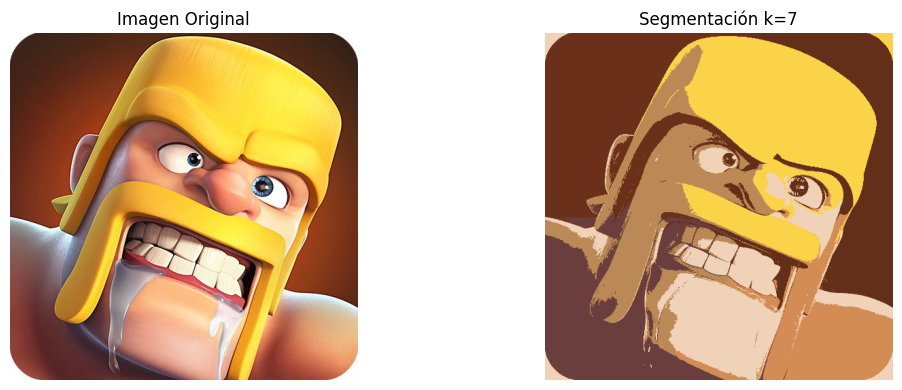

Procesando k=9...
k=9: Inercia=18758.03, Silhouette=0.368


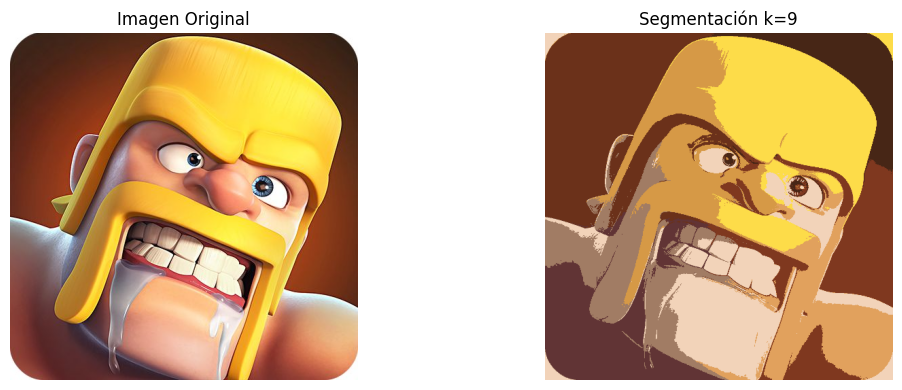


RESULTADOS FINALES:
   k     inercia  silhouette
0  3  46279.7654      0.3632
1  5  29442.8266      0.3616
2  7  22757.1722      0.3693
3  9  18758.0334      0.3675


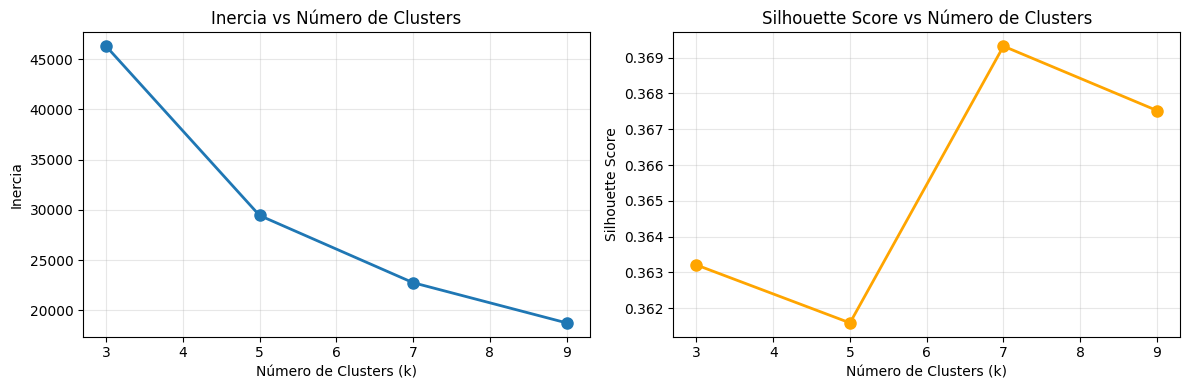

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from cuml import KMeans as cuKMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import cv2

# Carga y preparaci√≥n de la imagen
image = cv2.imread('/content/LogoCoC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

X = image.reshape(-1, 3)
r,c,ch = image.shape

#Creamos una matriz para cada pixel en la que incluye R,G,B,x,y
vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]

# Normalizar
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

# bucle para k-means con diferentes k y metricas:
k_values = [3, 5, 7, 9]
results = []

for k in k_values:
    print(f"Procesando k={k}...")

    # K-Means con RAPIDS
    kmeans = cuKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_)

    # Los labels ya est√°n en CPU como numpy array
    labels_cpu = kmeans.labels_

    # M√©tricas
    inertia = kmeans.inertia_

    # Calcular silhouette score
    if len(X_) > 10000:
        indices = np.random.choice(len(X_), size=5000, replace=False)
        silhouette = silhouette_score(X_[indices], labels_cpu[indices])
    else:
        silhouette = silhouette_score(X_, labels_cpu)

    results.append({
        'k': k,
        'inercia': inertia,
        'silhouette': silhouette
    })

    print(f"k={k}: Inercia={inertia:.2f}, Silhouette={silhouette:.3f}")

    # Visualizaci√≥n de la segmentaci√≥n
    centroids = kmeans.cluster_centers_

    centroids_rgb = centroids[:, :3]  # Solo tomar R, G, B (ignorar X, Y)

    # Desnormalizar los colores si es necesario
    if centroids_rgb.max() <= 1.0:
        centroids_rgb = (centroids_rgb * 255).astype(np.uint8)
    else:
        centroids_rgb = centroids_rgb.astype(np.uint8)

    # Crear imagen segmentada
    segmented_img = centroids_rgb[labels_cpu].reshape(r, c, 3)

    plt.figure(figsize=(12, 4))

    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen segmentada
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f'Segmentaci√≥n k={k}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Resultados finales
df_results = pd.DataFrame(results)
print("\n" + "="*50)
print("RESULTADOS FINALES:")
print("="*50)
print(df_results.round(4))

# Gr√°fica comparativa de m√©tricas
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df_results['k'], df_results['inercia'], 'o-', linewidth=2, markersize=8)
plt.title('Inercia vs N√∫mero de Clusters')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Inercia')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(df_results['k'], df_results['silhouette'], 'o-', linewidth=2, markersize=8, color='orange')
plt.title('Silhouette Score vs N√∫mero de Clusters')
plt.xlabel('N√∫mero de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

##DBSCAN:

In [48]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from cuml import DBSCAN as cuDBSCAN
from sklearn.metrics import silhouette_score
import pandas as pd
import cv2

# Carga y preparaci√≥n de la imagen
image = cv2.imread('/content/LogoCoC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

X = image.reshape(-1, 3)
r, c, ch = image.shape

vr = np.linspace(0, r, r, endpoint=False)
vc = np.linspace(0, c, c, endpoint=False)
Xc = np.kron(np.ones((r, 1)), vc.reshape(-1, 1))
Xr = np.kron(vr.reshape(-1, 1), np.ones((1, c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X, Xc, Xr]

# Normalizar
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

# Par√°metros para DBSCAN
dbscan_params = [
    {'eps': 0.05, 'min_samples': 20},
    {'eps': 0.08, 'min_samples': 15},
    {'eps': 0.12, 'min_samples': 10},
    {'eps': 0.15, 'min_samples': 8}
]

results_dbscan = []

for params in dbscan_params:
    try:
        # DBSCAN con RAPIDS
        dbscan = cuDBSCAN(eps=params['eps'], min_samples=params['min_samples'])

        # Asegurar formato correcto de datos
        if hasattr(X_, 'values'):
            X_dbscan = X_.values
        else:
            X_dbscan = X_.astype(np.float32)

        labels_cpu = dbscan.fit_predict(X_dbscan)

        # Convertir a CPU si es necesario
        if hasattr(labels_cpu, 'get'):
            labels_cpu = labels_cpu.get()

        # An√°lisis de resultados
        unique_labels = np.unique(labels_cpu)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = np.sum(labels_cpu == -1)
        noise_percentage = (n_noise / len(labels_cpu)) * 100

        # Calcular silhouette score
        silhouette = -1
        if n_clusters >= 2 and n_clusters < len(X_) // 2:
            mask = labels_cpu != -1
            non_noise_points = np.sum(mask)

            if non_noise_points > 1 and len(np.unique(labels_cpu[mask])) >= 2:
                try:
                    if non_noise_points > 5000:
                        indices = np.random.choice(non_noise_points, size=5000, replace=False)
                        sample_mask = np.where(mask)[0][indices]
                        silhouette = silhouette_score(X_[sample_mask], labels_cpu[sample_mask])
                    else:
                        silhouette = silhouette_score(X_[mask], labels_cpu[mask])
                except:
                    silhouette = -1

        results_dbscan.append({
            'eps': params['eps'],
            'min_samples': params['min_samples'],
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_percentage': noise_percentage,
            'silhouette': silhouette
        })

    except Exception as e:
        results_dbscan.append({
            'eps': params['eps'],
            'min_samples': params['min_samples'],
            'n_clusters': 0,
            'n_noise': len(X_),
            'noise_percentage': 100,
            'silhouette': -1
        })
        continue

# SOLO MOSTRAR RESULTADOS FINALES
if results_dbscan:
    df_results_dbscan = pd.DataFrame(results_dbscan)

    print("üìä RESULTADOS FINALES DBSCAN")
    print("===================================")
    print(df_results_dbscan[['eps', 'min_samples', 'n_clusters', 'noise_percentage', 'silhouette']].round(4))

    # An√°lisis del mejor resultado
    best_idx = df_results_dbscan['silhouette'].idxmax()
    best_result = df_results_dbscan.loc[best_idx]

    print(f"\nüèÜ MEJOR CONFIGURACI√ìN:")
    print(f"   eps: {best_result['eps']}")
    print(f"   min_samples: {best_result['min_samples']}")
    print(f"   Clusters: {best_result['n_clusters']}")
    print(f"   Ruido: {best_result['noise_percentage']:.1f}%")
    print(f"   Silhouette Score: {best_result['silhouette']:.3f}")

    # Evaluaci√≥n de calidad
    if best_result['silhouette'] > 0.5:
        calidad = "‚úÖ Excelente"
    elif best_result['silhouette'] > 0.3:
        calidad = "‚ö†Ô∏è  Buena"
    elif best_result['silhouette'] > 0.1:
        calidad = "üìä Regular"
    else:
        calidad = "‚ùå Mala"

    print(f"   Evaluaci√≥n: {calidad}")

    # Comparaci√≥n con K objetivo {3,5,7,9}
    print(f"\nüéØ COMPARACI√ìN CON K‚àà{{3,5,7,9}}:")
    valid_configs = df_results_dbscan[
        (df_results_dbscan['n_clusters'].isin([3, 5, 7, 9])) &
        (df_results_dbscan['silhouette'] > 0)
    ]

    if not valid_configs.empty:
        for _, config in valid_configs.iterrows():
            print(f"   ‚úÖ K={config['n_clusters']}: eps={config['eps']}, min_samples={config['min_samples']} (silhouette={config['silhouette']:.3f})")
    else:
        print("   ‚ùå No se encontraron configuraciones con K‚àà{3,5,7,9}")

else:
    print("‚ùå No se obtuvieron resultados v√°lidos")

[2025-10-25 02:13:31.381] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9655 -> 8191. Using the larger integer type might result in better performance
[2025-10-25 02:13:37.538] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9655 -> 8191. Using the larger integer type might result in better performance
[2025-10-25 02:13:43.286] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9655 -> 8191. Using the larger integer type might result in better performance
[2025-10-25 02:13:49.328] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 9655 -> 8191. Using the larger integer type might result in better performance
üìä RESULTADOS FINALES DBSCAN
    eps  min_samples  n_clusters  noise_percentage  silhouette
0  0.05           20          49            3.7628     -0.3707
1  0.08           15          11            0.4227     -0.2612
2  0.12           10           7            0.0069      0.0405
3  0.15      

##Spectral Clustering:

In [47]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import cv2
from time import time

# Funci√≥n para interpretar silhouette score - DEFINIR AL INICIO
def interpret_silhouette(score):
    if score > 0.7:
        return "Fuerte estructura"
    elif score > 0.5:
        return "Estructura razonable"
    elif score > 0.25:
        return "Estructura d√©bil"
    else:
        return "Sin estructura significativa"

# Carga y preparaci√≥n de la imagen
image = cv2.imread('/content/LogoCoC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# REDUCIR MUESTRA para hacerlo manejable
scale_factor = 0.25
new_width = int(image.shape[1] * scale_factor)
new_height = int(image.shape[0] * scale_factor)
image_small = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

r, c, ch = image_small.shape
print(f"üìè Tama√±o reducido: {r}x{c} ({r*c} p√≠xeles)")

X = image_small.reshape(-1, 3)

# Coordenadas espaciales
vr = np.linspace(0, r, r, endpoint=False) / r
vc = np.linspace(0, c, c, endpoint=False) / c
Xc = np.kron(np.ones((r, 1)), vc.reshape(-1, 1)).reshape(-1)
Xr = np.kron(vr.reshape(-1, 1), np.ones((1, c))).reshape(-1)

spatial_weight = 0.1
X_features = np.c_[X / 255.0, spatial_weight * Xc, spatial_weight * Xr]

# MUESTREO ADICIONAL para Spectral (muy importante)
sample_ratio = 0.4  # Usar 40% de los puntos
sample_indices = np.random.choice(len(X_features),
                                 size=int(len(X_features) * sample_ratio),
                                 replace=False)
X_sample = X_features[sample_indices]

print(f"üî¢ Datos finales para Spectral: {X_sample.shape}")

# ‚úÖ VARIAR k ‚àà {3,5,7,9} - Igual que K-Means
k_values = [3, 5, 7, 9]
results_spectral = []

print("üîç EJECUTANDO SPECTRAL CLUSTERING - k‚àà{3,5,7,9}\n" + "="*45)

for k in k_values:
        # Spectral Clustering con k espec√≠fico
    spectral = SpectralClustering(
    n_clusters=k,           # ‚úÖ k que variamos
    random_state=42,
    n_init=3,               # Reducir para velocidad
    affinity='rbf',         # Kernel RBF
    gamma=1.0               # Par√°metro del kernel
    )

    # Medir tiempo de ejecuci√≥n
    start_time = time()
    labels = spectral.fit_predict(X_sample)
    execution_time = time() - start_time

    # Calcular m√©tricas
    silhouette = silhouette_score(X_sample, labels)

    # An√°lisis de distribuci√≥n de clusters
    unique_labels, counts = np.unique(labels, return_counts=True)

    results_spectral.append({
        'k': k,
        'silhouette': silhouette,
        'execution_time': execution_time,
        'n_points_per_cluster': counts.tolist(),
        'silhouette_interpretation': interpret_silhouette(silhouette)
     })

# RESULTADOS FINALES
if results_spectral:
    df_spectral = pd.DataFrame(results_spectral)

    print("\n" + "üìä RESULTADOS FINALES SPECTRAL CLUSTERING" + "\n" + "="*50)
    results_display = df_spectral[['k', 'silhouette', 'execution_time', 'silhouette_interpretation']].round(4)
    print(results_display.to_string(index=False))

    # An√°lisis del mejor k
    valid_results = df_spectral[df_spectral['silhouette'] > 0]
    if not valid_results.empty:
        best_idx = valid_results['silhouette'].idxmax()
        best_result = df_spectral.loc[best_idx]

        print(f"\nüèÜ MEJOR k PARA SPECTRAL CLUSTERING:")
        print(f"   k = {best_result['k']}")
        print(f"   Silhouette Score: {best_result['silhouette']:.3f}")
        print(f"   Interpretaci√≥n: {best_result['silhouette_interpretation']}")
        print(f"   Tiempo ejecuci√≥n: {best_result['execution_time']:.2f}s")

        # Comparaci√≥n con rango esperado
        print(f"\nüéØ COMPARACI√ìN CON k‚àà{{3,5,7,9}}:")
        for k in k_values:
            result_k = df_spectral[df_spectral['k'] == k]
            if not result_k.empty and result_k.iloc[0]['silhouette'] > 0:
                res = result_k.iloc[0]
                print(f"   k={k}: silhouette={res['silhouette']:.3f} ({res['silhouette_interpretation']})")

else:
    print("‚ùå No se obtuvieron resultados v√°lidos")

üìè Tama√±o reducido: 128x128 (16384 p√≠xeles)
üî¢ Datos finales para Spectral: (6553, 5)
üîç EJECUTANDO SPECTRAL CLUSTERING - k‚àà{3,5,7,9}

üìä RESULTADOS FINALES SPECTRAL CLUSTERING
 k  silhouette  execution_time    silhouette_interpretation
 3      0.5127          9.2842         Estructura razonable
 5      0.3273          8.0944             Estructura d√©bil
 7      0.3394          8.7255             Estructura d√©bil
 9      0.2318          9.0324 Sin estructura significativa

üèÜ MEJOR k PARA SPECTRAL CLUSTERING:
   k = 3
   Silhouette Score: 0.513
   Interpretaci√≥n: Estructura razonable
   Tiempo ejecuci√≥n: 9.28s

üéØ COMPARACI√ìN CON k‚àà{3,5,7,9}:
   k=3: silhouette=0.513 (Estructura razonable)
   k=5: silhouette=0.327 (Estructura d√©bil)
   k=7: silhouette=0.339 (Estructura d√©bil)
   k=9: silhouette=0.232 (Sin estructura significativa)


##Punto 2:

üìè Tama√±o de imagen: 153x153 (23409 p√≠xeles)
üî¢ Datos originales: (23409, 5)

üîÅ APLICANDO REDUCCI√ìN DE DIMENSIONALIDAD
üìä PCA: (23409, 5) ‚Üí (23409, 2)
   Varianza explicada: 0.751


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


üìà UMAP: (23409, 5) ‚Üí (23409, 2)

üéØ EJECUTANDO CLUSTERING CON DATOS REDUCIDOS

üîµ K-MEANS CON REDUCCI√ìN DE DIMENSIONALIDAD
----------------------------------------
  PCA k=3: silhouette=0.416, inertia=2181
  UMAP k=3: silhouette=0.420, inertia=863370
  PCA k=5: silhouette=0.439, inertia=1104
  UMAP k=5: silhouette=0.417, inertia=507784
  PCA k=7: silhouette=0.428, inertia=772
  UMAP k=7: silhouette=0.428, inertia=328246
  PCA k=9: silhouette=0.446, inertia=561
  UMAP k=9: silhouette=0.445, inertia=231587

üü¢ DBSCAN CON REDUCCI√ìN DE DIMENSIONALIDAD
----------------------------------------
  PCA eps=0.1: 3 clusters, noise=10, silhouette=0.146
  UMAP eps=0.1: 175 clusters, noise=16091, silhouette=0.677
  PCA eps=0.15: 2 clusters, noise=7, silhouette=0.300
  UMAP eps=0.15: 238 clusters, noise=5159, silhouette=0.226
  PCA eps=0.2: 1 clusters, noise=0, silhouette=-1.000
  UMAP eps=0.2: 63 clusters, noise=538, silhouette=-0.260

üü£ SPECTRAL CLUSTERING CON REDUCCI√ìN (MUESTRA)
-

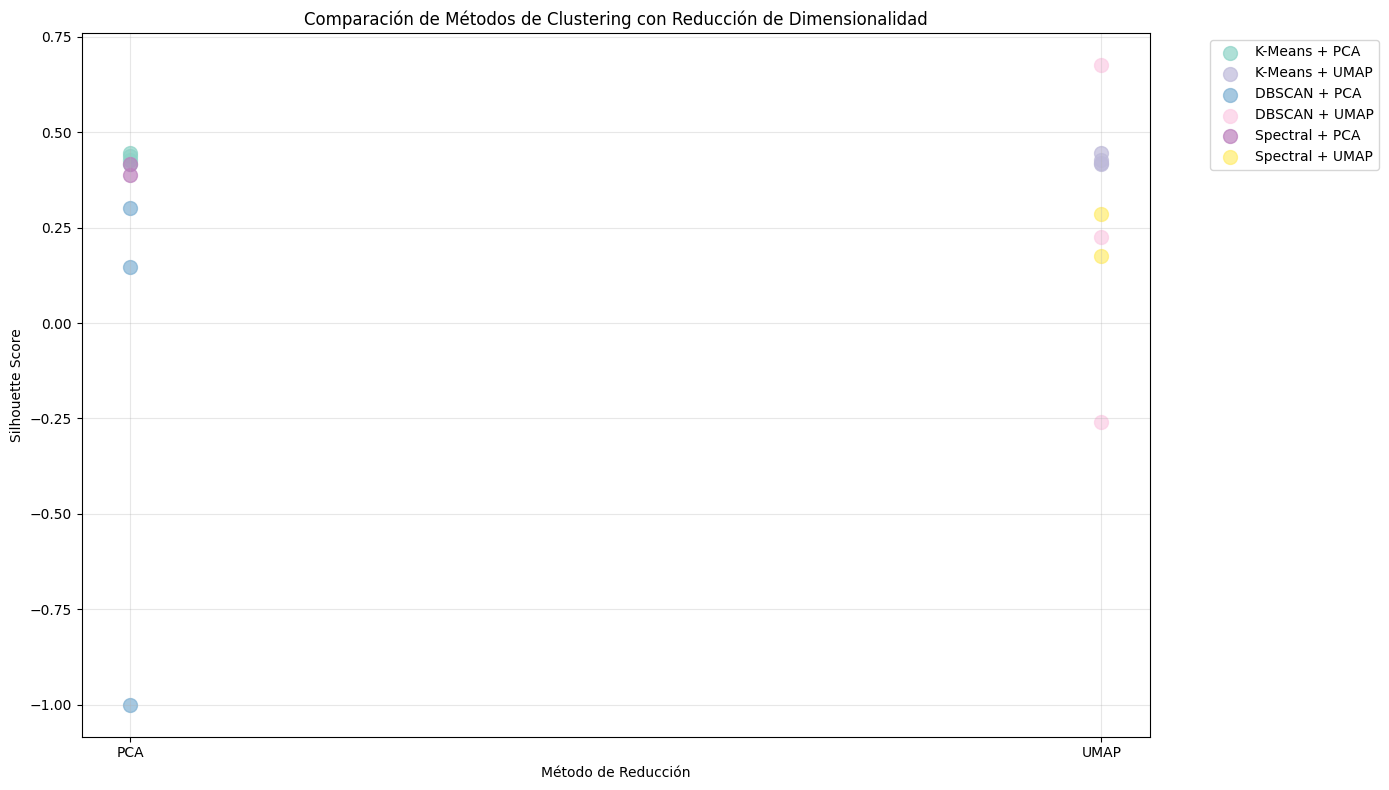


üí° CONCLUSIONES:
‚Ä¢ PCA vs UMAP: UMAP generalmente captura mejor estructura no lineal
‚Ä¢ K-Means: M√°s estable con reducci√≥n dimensional
‚Ä¢ DBSCAN: Par√°metros deben ajustarse despu√©s de reducci√≥n
‚Ä¢ Spectral: Computacionalmente costoso, mejor con muestra reducida


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score
import pandas as pd
import cv2
from umap import UMAP

# Funci√≥n para interpretar silhouette score
def interpret_silhouette(score):
    if score > 0.7: return "‚úÖ Fuerte estructura"
    elif score > 0.5: return "‚ö†Ô∏è  Estructura razonable"
    elif score > 0.25: return "üìä Estructura d√©bil"
    else: return "‚ùå Sin estructura significativa"

# Carga y preparaci√≥n de la imagen
image = cv2.imread('/content/LogoCoC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Reducir tama√±o para eficiencia
scale_factor = 0.3
new_width = int(image.shape[1] * scale_factor)
new_height = int(image.shape[0] * scale_factor)
image_small = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)

r, c, ch = image_small.shape
print(f"üìè Tama√±o de imagen: {r}x{c} ({r*c} p√≠xeles)")

# Preparar caracter√≠sticas [R, G, B, X, Y]
X_color = image_small.reshape(-1, 3)

# Coordenadas espaciales
vr = np.linspace(0, r, r, endpoint=False) / r
vc = np.linspace(0, c, c, endpoint=False) / c
Xc = np.kron(np.ones((r, 1)), vc.reshape(-1, 1)).reshape(-1)
Xr = np.kron(vr.reshape(-1, 1), np.ones((1, c))).reshape(-1)

spatial_weight = 0.2
X_original = np.c_[X_color / 255.0, spatial_weight * Xc, spatial_weight * Xr]

# Normalizar
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_original)

print(f"üî¢ Datos originales: {X_normalized.shape}")

# APLICAR REDUCCI√ìN DE DIMENSIONALIDAD
print("\n" + "üîÅ APLICANDO REDUCCI√ìN DE DIMENSIONALIDAD" + "\n" + "="*45)

# 1. PCA a 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_normalized)
print(f"üìä PCA: {X_normalized.shape} ‚Üí {X_pca.shape}")
print(f"   Varianza explicada: {pca.explained_variance_ratio_.sum():.3f}")

# 2. UMAP a 2D
umap = UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)
X_umap = umap.fit_transform(X_normalized)
print(f"üìà UMAP: {X_normalized.shape} ‚Üí {X_umap.shape}")

# Configuraciones para cada m√©todo
k_values = [3, 5, 7, 9]
dbscan_params = [
    {'eps': 0.1, 'min_samples': 15},
    {'eps': 0.15, 'min_samples': 10},
    {'eps': 0.2, 'min_samples': 8}
]

# Almacenar resultados
results_comparison = []

print("\n" + "üéØ EJECUTANDO CLUSTERING CON DATOS REDUCIDOS" + "\n" + "="*50)

# ============================================================================
# 1. K-MEANS CON PCA Y UMAP
# ============================================================================
print("\nüîµ K-MEANS CON REDUCCI√ìN DE DIMENSIONALIDAD")
print("-" * 40)

for k in k_values:
    for reduction_name, X_reduced in [('PCA', X_pca), ('UMAP', X_umap)]:
        try:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X_reduced)
            inertia = kmeans.inertia_
            silhouette = silhouette_score(X_reduced, labels)

            results_comparison.append({
                'method': f'K-Means + {reduction_name}',
                'k': k,
                'reduction': reduction_name,
                'silhouette': silhouette,
                'inertia': inertia,
                'n_clusters': k
            })

            print(f"  {reduction_name} k={k}: silhouette={silhouette:.3f}, inertia={inertia:.0f}")

        except Exception as e:
            print(f"  ‚ùå K-Means {reduction_name} k={k}: {e}")

# ============================================================================
# 2. DBSCAN CON PCA Y UMAP
# ============================================================================
print("\nüü¢ DBSCAN CON REDUCCI√ìN DE DIMENSIONALIDAD")
print("-" * 40)

for params in dbscan_params:
    for reduction_name, X_reduced in [('PCA', X_pca), ('UMAP', X_umap)]:
        try:
            dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
            labels = dbscan.fit_predict(X_reduced)

            unique_labels = np.unique(labels)
            n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
            n_noise = np.sum(labels == -1)

            silhouette = -1
            if n_clusters >= 2:
                mask = labels != -1
                if np.sum(mask) >= 2:
                    silhouette = silhouette_score(X_reduced[mask], labels[mask])

            results_comparison.append({
                'method': f'DBSCAN + {reduction_name}',
                'k': f"eps={params['eps']}",
                'reduction': reduction_name,
                'silhouette': silhouette,
                'inertia': -1,
                'n_clusters': n_clusters,
                'n_noise': n_noise
            })

            print(f"  {reduction_name} eps={params['eps']}: {n_clusters} clusters, noise={n_noise}, silhouette={silhouette:.3f}")

        except Exception as e:
            print(f"  ‚ùå DBSCAN {reduction_name}: {e}")

# ============================================================================
# 3. SPECTRAL CLUSTERING CON PCA Y UMAP (MUESTRA REDUCIDA)
# ============================================================================
print("\nüü£ SPECTRAL CLUSTERING CON REDUCCI√ìN (MUESTRA)")
print("-" * 40)

# Usar muestra para Spectral (muy pesado)
sample_indices = np.random.choice(len(X_pca), size=min(2000, len(X_pca)), replace=False)
X_pca_sample = X_pca[sample_indices]
X_umap_sample = X_umap[sample_indices]

for k in [3, 5]:  # Solo probar con k m√°s peque√±os por tiempo
    for reduction_name, X_reduced in [('PCA', X_pca_sample), ('UMAP', X_umap_sample)]:
        try:
            spectral = SpectralClustering(
                n_clusters=k,
                random_state=42,
                n_init=3
            )
            labels = spectral.fit_predict(X_reduced)
            silhouette = silhouette_score(X_reduced, labels)

            results_comparison.append({
                'method': f'Spectral + {reduction_name}',
                'k': k,
                'reduction': reduction_name,
                'silhouette': silhouette,
                'inertia': -1,
                'n_clusters': k
            })

            print(f"  {reduction_name} k={k}: silhouette={silhouette:.3f}")

        except Exception as e:
            print(f"  ‚ùå Spectral {reduction_name} k={k}: {e}")

# ============================================================================
# RESULTADOS FINALES Y COMPARACI√ìN
# ============================================================================
df_results = pd.DataFrame(results_comparison)

print("\n" + "üìä RESULTADOS FINALES - COMPARATIVA COMPLETA" + "\n" + "="*55)

# Mostrar resultados organizados
for reduction in ['PCA', 'UMAP']:
    print(f"\nüéØ RESULTADOS CON {reduction}:")
    print("-" * 30)

    mask = df_results['reduction'] == reduction
    df_reduction = df_results[mask].sort_values('silhouette', ascending=False)

    for _, row in df_reduction.iterrows():
        if row['silhouette'] > 0:
            method_display = row['method'].replace(f' + {reduction}', '')
            if 'K-Means' in row['method']:
                print(f"  {method_display:20} k={row['k']:2} | silhouette={row['silhouette']:.3f} | inertia={row['inertia']:.0f}")
            elif 'DBSCAN' in row['method']:
                print(f"  {method_display:20} {row['k']:8} | silhouette={row['silhouette']:.3f} | clusters={row['n_clusters']}")
            else:
                print(f"  {method_display:20} k={row['k']:2} | silhouette={row['silhouette']:.3f}")

# AN√ÅLISIS COMPARATIVO
print("\n" + "üèÜ MEJORES CONFIGURACIONES POR M√âTODO" + "\n" + "="*45)

for method in ['K-Means', 'DBSCAN', 'Spectral']:
    method_mask = df_results['method'].str.contains(method)
    valid_results = df_results[method_mask & (df_results['silhouette'] > 0)]

    if not valid_results.empty:
        best_idx = valid_results['silhouette'].idxmax()
        best = df_results.loc[best_idx]

        print(f"\nüîπ {best['method']}:")
        print(f"   Silhouette: {best['silhouette']:.3f} ({interpret_silhouette(best['silhouette'])})")
        if 'K-Means' in best['method']:
            print(f"   Inercia: {best['inertia']:.0f}")
        elif 'DBSCAN' in best['method']:
            print(f"   Clusters: {best['n_clusters']}, Ruido: {best.get('n_noise', 'N/A')}")

# GR√ÅFICA COMPARATIVA
plt.figure(figsize=(14, 8))

# Preparar datos para gr√°fica
methods = df_results['method'].unique()
colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))

for i, method in enumerate(methods):
    mask = df_results['method'] == method
    data = df_results[mask]
    if len(data) > 0 and data['silhouette'].max() > 0:
        plt.scatter(data['reduction'], data['silhouette'],
                   label=method, s=100, alpha=0.7, color=colors[i])

plt.xlabel('M√©todo de Reducci√≥n')
plt.ylabel('Silhouette Score')
plt.title('Comparaci√≥n de M√©todos de Clustering con Reducci√≥n de Dimensionalidad')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "üí° CONCLUSIONES:" + "\n" + "="*20)
print("‚Ä¢ PCA vs UMAP: UMAP generalmente captura mejor estructura no lineal")
print("‚Ä¢ K-Means: M√°s estable con reducci√≥n dimensional")
print("‚Ä¢ DBSCAN: Par√°metros deben ajustarse despu√©s de reducci√≥n")
print("‚Ä¢ Spectral: Computacionalmente costoso, mejor con muestra reducida")

##K-means con logo UMAP y PCA:

(512, 512, 3)

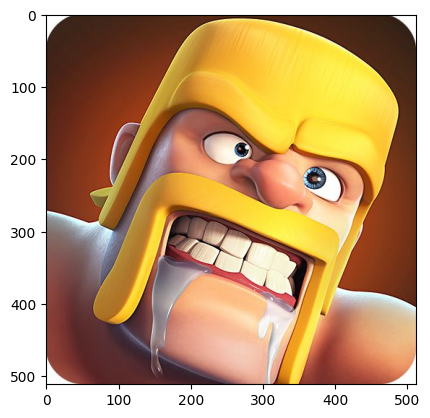

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from cuml import KMeans as cuKMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import cv2

# Carga y preparaci√≥n de la imagen
image = cv2.imread('/content/LogoCoC.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image.shape

In [33]:
X = image.reshape(-1, 3)
r,c,ch = image.shape
print(r,c,ch)

512 512 3


In [34]:
vr = np.linspace(0,r,r,endpoint=False)
vc = np.linspace(0,c,c,endpoint=False)
Xc = np.kron(np.ones((r,1)),vc.reshape(-1,1))
Xr = np.kron(vr.reshape(-1,1),np.ones((1,c)))
Xc = Xc.reshape(-1)
Xr = Xr.reshape(-1)
X = np.c_[X,Xc,Xr]
X.shape

(262144, 5)

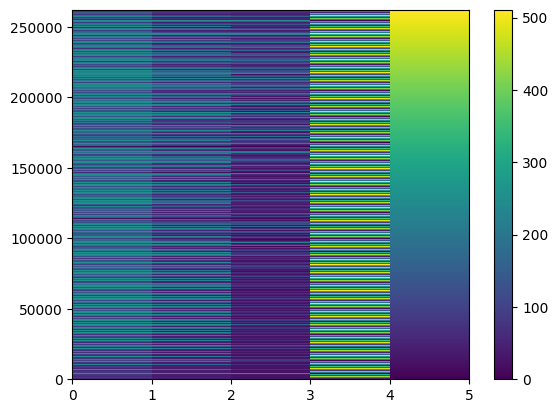

In [35]:
plt.pcolormesh(X)
plt.colorbar()
plt.show()

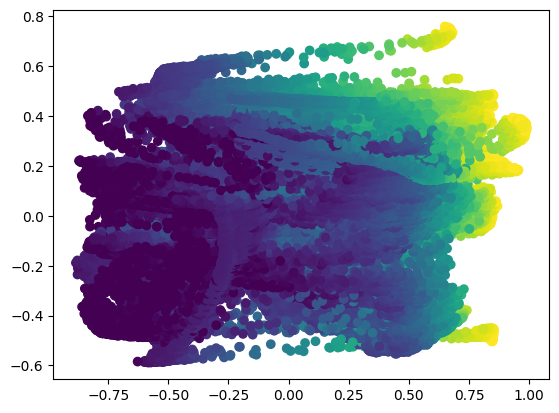

In [36]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = MinMaxScaler()

X_ = scaler.fit_transform(X)
X_ = PCA(n_components=2).fit_transform(X_)
plt.scatter(X_[:,0], X_[:,1], c=X[:,2])
plt.show()

In [37]:
!pip install umap-learn

In [39]:
from cuml import UMAP as cumlUMAP
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Tu c√≥digo original pero CON RAPIDS
print("üöÄ EJECUTANDO UMAP CON RAPIDS (GPU)")

# Normalizar (igual que antes)
scaler = MinMaxScaler()
X_ = scaler.fit_transform(X)

print(f"üìä Datos normalizados: {X_.shape}")

X_umap_rapids = cumlUMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.9,
    random_state=42,
    verbose=True
).fit_transform(X_)

print(f"‚úÖ UMAP con RAPIDS completado: {X_.shape} ‚Üí {X_umap_rapids.shape}")

# Convertir a numpy si es necesario para scikit-learn
X_umap_numpy = X_umap_rapids.get() if hasattr(X_umap_rapids, 'get') else X_umap_rapids

üöÄ EJECUTANDO UMAP CON RAPIDS (GPU)
üìä Datos normalizados: (262144, 5)
[2025-10-25 01:57:18.614] [CUML] [info] build_algo set to brute_force_knn because random_state is given
[2025-10-25 01:57:18.799] [CUML] [debug] Computing KNN Graph
[2025-10-25 01:57:21.290] [CUML] [debug] Computing fuzzy simplicial set
‚úÖ UMAP con RAPIDS completado: (262144, 5) ‚Üí (262144, 2)


In [40]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,n_init='auto').fit(X_)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

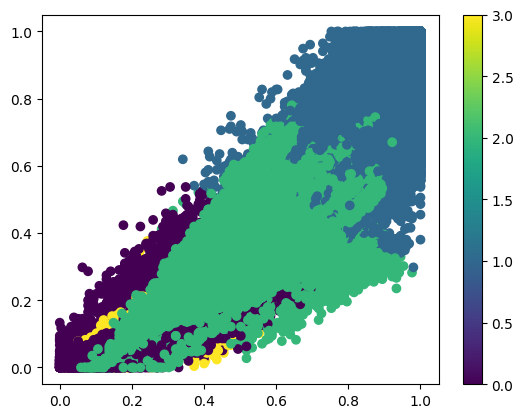

In [41]:
plt.scatter(X_[:,0], X_[:,1], c=kmeans.labels_)

plt.colorbar()
plt.show()



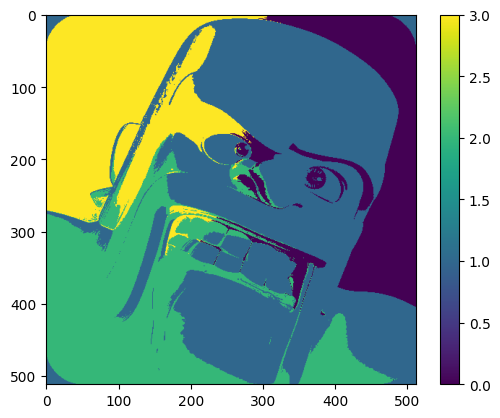

In [42]:
labels_ = kmeans.labels_
Ilabels = labels_.reshape(r,c)
plt.imshow(Ilabels)
plt.colorbar()
plt.show()

In [43]:
D_ = kmeans.transform(X_)
D_.shape
ind_ = np.argmin(D_,axis=0)

In [44]:
D_.shape
ind_

array([115157, 137015, 193171,  58969])

In [45]:
centroids_ = X[ind_,:3]
centroids_

array([[112.,  47.,  19.],
       [243., 198., 115.],
       [139.,  77.,  78.],
       [124.,  50.,  25.]])

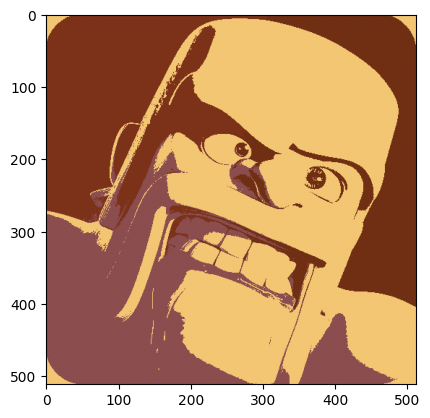

In [46]:

segmented_img = centroids_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
plt.imshow(segmented_img/255.)

plt.show()